In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import argparse
import os
import tqdm
import scipy.ndimage as nd
from torchvision import transforms
import matplotlib.pyplot as plt


plt.rcParams['figure.figsize'] = 15, 10

In [146]:
import os
!wget https://images.wallpaperscraft.com/image/paint_fluid_art_stains_183755_1280x720.jpg

--2020-08-29 15:23:45--  https://images.wallpaperscraft.com/image/paint_fluid_art_stains_183755_1280x720.jpg
Resolving images.wallpaperscraft.com (images.wallpaperscraft.com)... 78.47.94.150, 78.47.91.113, 78.46.212.205, ...
Connecting to images.wallpaperscraft.com (images.wallpaperscraft.com)|78.47.94.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162124 (158K) [image/jpeg]
Saving to: ‘paint_fluid_art_stains_183755_1280x720.jpg.1’

paint_fluid_art_sta 100%[===================>] 158.32K   773KB/s    in 0.2s    

2020-08-29 15:23:45 (773 KB/s) - ‘paint_fluid_art_stains_183755_1280x720.jpg.1’ saved [162124/162124]



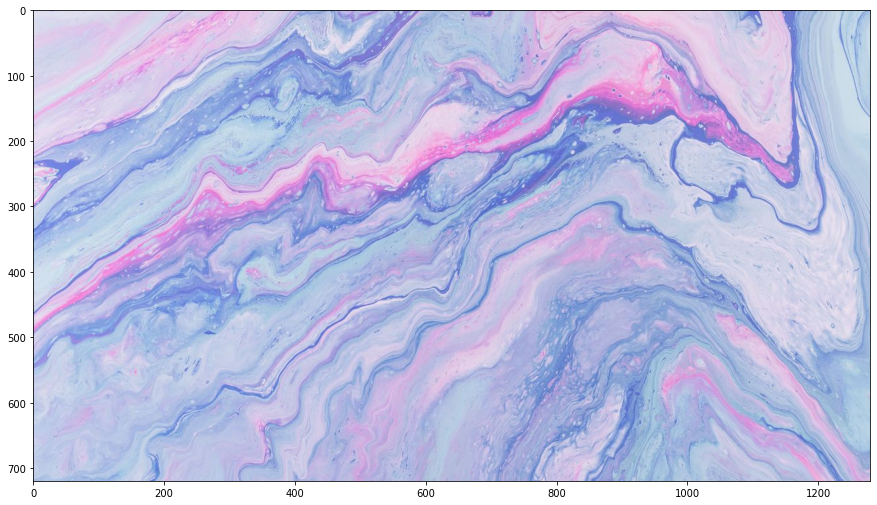

In [147]:
import cv2 

image = cv2.imread("paint_fluid_art_stains_183755_1280x720.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# image = cv2.resize(image, (1024,1024))

plt.imshow(image)
plt.show()

In [92]:
print(image.shape)

(720, 1280, 3)


In [148]:
model = models.vgg19(pretrained=True)
layers = list(model.features.children())
model.eval()
if torch.cuda.is_available:
    model = model.cuda()
# print(model)

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
preprocess = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

In [127]:

class Hook():
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()



In [149]:

#Function to make gradients calculations from the output channels of the target layer.
def get_gradients(net_in, net, layer, out_channels = None):     
    net_in = net_in.unsqueeze(0).cuda()
    net_in.requires_grad = True
    net.zero_grad()
    hook = Hook(layer)
    net_out = net(net_in)
    if out_channels == None:
        loss = hook.output[0].norm()
    else:
        loss = hook.output[0][out_channels].norm()
    loss.backward()
    return net_in.grad.data.squeeze()

#Function to run the dream. The excesive casts to and from numpy arrays is to make use of the np.roll() function.
#By rolling the image randomly everytime the gradients are computed, we prevent a tile effect artifact from appearing.
def dream(image, net, layer, iterations, lr, out_channels = None):
    image_numpy = np.array(image)
    image_tensor = transforms.ToTensor()(image_numpy)
    image_tensor = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image_tensor).cuda()
    denorm = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),                 
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),                                                     
                                ])
    for i in range(iterations):
        roll_x = np.random.randint(image_numpy.shape[0])
        roll_y = np.random.randint(image_numpy.shape[1])
        img_roll = np.roll(np.roll(image_tensor.detach().cpu().numpy().transpose(1,2,0), roll_y, 0), roll_x, 1)
        img_roll_tensor = torch.tensor(img_roll.transpose(2,0,1), dtype = torch.float)
        gradients_np = get_gradients(img_roll_tensor, net, layer, out_channels).detach().cpu().numpy()
        gradients_np = np.roll(np.roll(gradients_np, -roll_y, 1), -roll_x, 2)
        gradients_tensor = torch.tensor(gradients_np).cuda()
        image_tensor.data = image_tensor.data + lr * gradients_tensor.data

    img_out = image_tensor.detach().cpu()
    img_out = denorm(img_out)
    img_out_np = img_out.numpy()
    img_out_np = img_out_np.transpose(1,2,0)
    img_out_np = np.clip(img_out_np, 0, 1)
    
    return img_out_np


In [152]:



orig_size = image.shape[:2]
new_size = tuple(np.array(image.shape[:2])*0.5)
layer = list( model.features.modules() )[27]

print(orig_size)
#To visualize features at different scales, the image is resized multiple times and run thru the dream
OCTAVE_SCALE = 1.5
for n in range(-7,1):
    new_size = tuple( np.array(orig_size) * OCTAVE_SCALE**n)

    new_size = (int(new_size[0]), int(new_size[1]))

    # print(new_size)

    image = cv2.resize(image, new_size)

    image = dream(image, model, layer, 50, 0.05, out_channels = None)



(1280, 720)


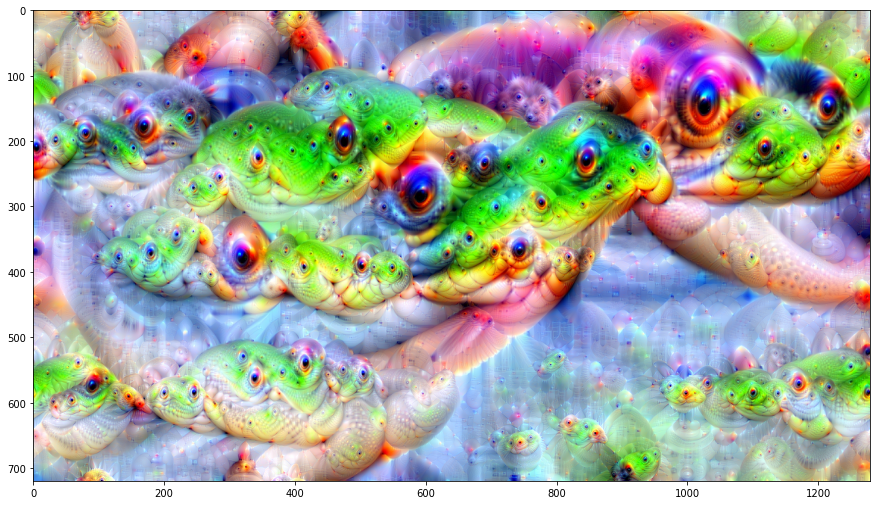

In [121]:
plt.imshow(image)